# EDA & Classical Time-Series Baselines

This notebook demonstrates exploratory data analysis (EDA) and baseline classical time-series modeling for the Natural Gas Price Forecasting project. It is intended to be run after `0_Data_preprocess_eda.ipynb` (which produces the cleaned merged dataset `data/price_vol_temp_inven_mc_merged_cleaned_data.csv`).

What this notebook contains:
- Quick data preview and temperature series used as exogenous variables.
- Stationarity checks (ADF), ACF/PACF visual inspection, and differencing guidance.
- Baseline models: ARIMA, SARIMAX, Exponential Smoothing and `pmdarima` auto_arima examples.
- Helper functions for preparing exogenous variables and plotting forecasts.

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the style of seaborn
sns.set(style="whitegrid")

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from pmdarima.utils import tsdisplay
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pmdarima as pm

%matplotlib widget

# Data and plot

In [9]:
file_path = 'price_vol_temp_inven_merged_cleaned_data.csv'
# Load the data
df = pd.read_csv(file_path, parse_dates=['date'])

# Set the date as index
df['date'] = df['date'].dt.date

# Set the date as index
#df.set_index('date', inplace=True)
#df.reset_index(inplace=True)

# Preview the data
df

date  psv_price  brent_price  ttf_futures_price  pvb_price  \
0     2009-01-01        NaN          NaN                NaN        NaN   
1     2009-01-02        NaN        46.91                NaN        NaN   
2     2009-01-05        NaN        49.62                NaN        NaN   
3     2009-01-06        NaN        50.53                NaN        NaN   
4     2009-01-07        NaN        45.86                NaN        NaN   
...          ...        ...          ...                ...        ...   
4431  2025-12-26        NaN          NaN                NaN        NaN   
4432  2025-12-29        NaN          NaN                NaN        NaN   
4433  2025-12-30        NaN          NaN                NaN        NaN   
4434  2025-12-31        NaN          NaN                NaN        NaN   
4435  2026-01-01        NaN          NaN                NaN        NaN   

      jkm_price  nbp_price  cboe_price  coal_price  hh_price  ttf_price  \
0           NaN        NaN         NaN         NaN       NaN      21.00   
1           NaN        NaN       39.19       74.35      5.41      22.20   
2           NaN        NaN       39.08       77.65      5.83      22.85   
3           NaN        NaN       38.56       81.25      6.10      26.00   
4           NaN        NaN       43.39       78.65      5.89      26.33   
...         ...        ...         ...         ...       ...        ...   
4431        NaN        NaN         NaN         NaN       NaN        NaN   
4432        NaN        NaN         NaN         NaN       NaN        NaN   
4433        NaN        NaN         NaN         NaN       NaN        NaN   
4434        NaN        NaN         NaN         NaN       NaN        NaN   
4435        NaN        NaN         NaN         NaN       NaN        NaN   

      brent_volume  ttf_futures_volume  coal_volume  temp_global  \
0              NaN                 NaN          NaN       12.580   
1          85070.0                 NaN          NaN       12.503   
2         109470.0                 NaN          NaN       12.432   
3         119830.0                 NaN          NaN       12.462   
4         130440.0                 NaN          NaN       12.436   
...            ...                 ...          ...          ...   
4431           NaN                 NaN          NaN          NaN   
4432           NaN                 NaN          NaN          NaN   
4433           NaN                 NaN          NaN          NaN   
4434           NaN                 NaN          NaN          NaN   
4435           NaN                 NaN          NaN          NaN   

      temp_southern_hemisphere  temp_northern_hemisphere  netimports_total  \
0                       15.963                     9.254          694352.0   
1                       15.952                     9.109           27910.0   
2                       16.191                     8.730           64498.0   
3                       16.244                     8.737          601994.0   
4                       16.229                     8.699         -980536.0   
...                        ...                       ...               ...   
4431                       NaN                       NaN               NaN   
4432                       NaN                       NaN               NaN   
4433                       NaN                       NaN               NaN   
4434                       NaN                       NaN               NaN   
4435                       NaN                       NaN               NaN   

      inventories_global  week_of_day  
0                    NaN            3  
1                    NaN            4  
2                    NaN            0  
3                    NaN            1  
4                    NaN            2  
...                  ...          ...  
4431                 NaN            4  
4432                 NaN            0  
4433                 NaN            1  
4434                 NaN            2  
4435                 NaN    

# Load the city temperature data

In [10]:
# Load the CSV file
t_file = 'temperature_data_6_regions.csv'
df_t = pd.read_csv(t_file, parse_dates=['date'])

# Keep only the date part (remove time)
df_t['date'] = df_t['date'].dt.date

# Set the date as index
#df_t.set_index('date', inplace=True)

# Preview data
df_t

date        jkm         hh        ttf        psv        pvb  \
0     2009-01-01   6.193716   6.266269   0.094442   7.786285  10.795788   
1     2009-01-02   7.335959  17.224785   1.579225   5.998459  10.847691   
2     2009-01-03   8.181699  19.955269  -0.503795   6.077274   9.228043   
3     2009-01-04   8.029143  20.170723   1.274718   5.009335   8.835560   
4     2009-01-05   7.944893  10.890604  -1.820566   4.762669   5.153366   
...          ...        ...        ...        ...        ...        ...   
6030  2025-07-06  29.699951  25.465096  22.737580  29.723503  30.455544   
6031  2025-07-07  29.114191  25.342670  19.326149  28.335629  29.425678   
6032  2025-07-08  29.781725  26.281120  19.311378  27.080639  27.589233   
6033  2025-07-09  29.436270  24.749405  21.166391  26.408058  28.702595   
6034  2025-07-10  28.142267  24.877296  23.507310  26.605621  29.390648   

            peg  
0      6.314228  
1      4.856506  
2      5.211918  
3      2.518314  
4      3.026861  
...         ...  
6030  22.723580  
6031  21.005398  
6032  22.544525  
6033  24.432117  
6034  25.492271  

[6035 rows x 7 columns]

In [6]:
df_t

date        jkm         hh        ttf        psv        pvb  \
0     2009-01-01   6.193716   6.266269   0.094442   7.786285  10.795788   
1     2009-01-02   7.335959  17.224785   1.579225   5.998459  10.847691   
2     2009-01-03   8.181699  19.955269  -0.503795   6.077274   9.228043   
3     2009-01-04   8.029143  20.170723   1.274718   5.009335   8.835560   
4     2009-01-05   7.944893  10.890604  -1.820566   4.762669   5.153366   
...          ...        ...        ...        ...        ...        ...   
6030  2025-07-06  29.699951  25.465096  22.737580  29.723503  30.455544   
6031  2025-07-07  29.114191  25.342670  19.326149  28.335629  29.425678   
6032  2025-07-08  29.781725  26.281120  19.311378  27.080639  27.589233   
6033  2025-07-09  29.436270  24.749405  21.166391  26.408058  28.702595   
6034  2025-07-10  28.142267  24.877296  23.507310  26.605621  29.390648   

            peg  
0      6.314228  
1      4.856506  
2      5.211918  
3      2.518314  
4      3.026861  
...         ...  
6030  22.723580  
6031  21.005398  
6032  22.544525  
6033  24.432117  
6034  25.492271  

[6035 rows x 7 columns]

# Time series modeling

## Functions

In [11]:
# Define function to fit ARIMA/SARIMAX model and forecast the next 100 periods
def data_prep(df, column, date_range=None):
    """
    Prepare the time series data for the specified column.
    
    Parameters:
    - df: DataFrame containing the time series data
    - column: Column name to prepare the data for
    - date_range: Optional tuple (start_date, end_date) to filter the series

    Returns:
    - series: The prepared time series DataFrame with date as index
    """
    # Prepare the series with date as index
    series = df[['date', column]].dropna(subset=[column])
    series = series.set_index('date')
    series = series.asfreq('B').interpolate()  # Business frequency daily

    if date_range is not None:
        if isinstance(date_range, tuple) and len(date_range) == 2:
            # Ensure date_range is a tuple of two dates
            date_range = pd.to_datetime(date_range)
        elif isinstance(date_range, pd.DatetimeIndex):
            # If date_range is a DatetimeIndex, convert to tuple
            date_range = (date_range[0], date_range[-1])
        else:
            raise ValueError("date_range must be a tuple of two dates or a DatetimeIndex.")
        # Filter the series based on the date range
        series = series[date_range[0]:date_range[1]]

    return series

def exog_prep_train_test(df, exog_column, data_train, steps=100):
    """
    Prepare exogenous variables for the model.
    
    Parameters:
    - df: DataFrame containing the time series data
    - exog_column: Column name to prepare the exogenous variable for
    - data_train: Training data series to align with
    - steps: Number of periods to forecast

    Returns:
    - exog: Prepared exogenous variable DataFrame with date as index
    """
    # Prepare the exogenous variable series
    exog_train = data_prep(df, exog_column, date_range=data_train.index)

    # Align with training data index
    exog_train = exog_train.reindex(data_train.index).fillna(0)

    # Extend for forecast period
    forecast_index = pd.date_range(start=data_train.index[-1] + pd.Timedelta(days=1), periods=steps, freq='B')
    exog_test = data_prep(df, exog_column, date_range=(forecast_index[0], forecast_index[-1]))

    # Check if exogenous variables contains any NaN values
    if exog_train.isnull().values.any():
        print("Warning: Exogenous variables contain NaN values. Filling with 0.")
        exog_train = exog_train.fillna(0)

    if exog_test.isnull().values.any():
        print("Warning: Exogenous variables for forecast contain NaN values. Filling with 0.")
        exog_test = exog_test.fillna(0)

    return exog_train, exog_test

def fit_arima_sarimax_and_forecast(series, order=(1, 1, 1), 
                                   seasonal_order=None, steps=100, print_summary=False, exog_train=None, exog_test=None):
    
    """
    Fit an ARIMA or SARIMAX model to the specified column and forecast the next `steps` periods.
    If `seasonal_order` is provided, SARIMAX is used; otherwise, ARIMA is used.
    
    Parameters:
    - df: DataFrame containing the time series data
    - column: Column name to fit the model on
    - date_range: Optional tuple (start_date, end_date) to filter the series
    - order: Tuple specifying the (p, d, q) order of the ARIMA/SARIMAX model
    - seasonal_order: Tuple (P, D, Q, s) for SARIMAX seasonality, or None for ARIMA
    - steps: Number of periods to forecast
    - print_summary: Whether to print the model summary
    - exog: Optional exogenous variables for SARIMAX

    Returns:
    - series: The time series used for fitting (DataFrame)
    - results: Fitted model results
    - forecast_index: Index for the forecasted values
    - forecast: Forecasted values object
    """
    # Prepare exogenous variables if provided
    exog_fit = None
    if exog_train is not None:
        exog_fit = exog_train.loc[series.index] if isinstance(exog_train, pd.DataFrame) else exog_train

    # Select model
    if seasonal_order is not None:
        model = SARIMAX(series, order=order, seasonal_order=seasonal_order, exog=exog_fit)
    else:
        model = ARIMA(series, order=order, exog=exog_fit)

    results = model.fit()

    if print_summary:
        print(results.summary())

    # Forecast
    forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=steps, freq='B')
    exog_forecast = None
    if exog_test is not None:
        # For forecasting, exog must have the same number of rows as steps
        if isinstance(exog_test, pd.DataFrame):
            exog_forecast = exog_test.reindex(forecast_index)
        else:
            exog_forecast = exog_test

    forecast = results.get_forecast(steps=steps, exog=exog_forecast)

    return results, forecast_index, forecast

# Plot the model fit and forecast, confidence intervals
def plot_forecast(series_train, fitted_values, forecast_values, conf_int, forecast_index, ylabel='Price', series_other=None, title=None):
    """
    Plot the model fit and forecast with confidence intervals.
    
    Parameters:
    - series: Original time series data (DataFrame)
    - fitted_values: Fitted values from the model (Series)
    - forecast_values: Forecasted values (Series)
    - conf_int: Confidence intervals for the forecast (Numpy array)
    - forecast_index: Index for the forecasted values (DatetimeIndex)
    """

    plt.figure(figsize=(10, 6))

    # Plot observed data
    plt.plot(series_train.index, series_train, label='Train', color='blue')

    # Plot fitted values
    plt.plot(series_train.index, fitted_values, label='Fitted', color='green', alpha=0.5)

    if series_other is not None:
        # Plot other series if provided
        plt.plot(series_other.index, series_other, label='Test', color='orange', linestyle='-')

    # Plot forecasted values
    plt.plot(forecast_index, forecast_values, label='Forecast', color='red')

    # Plot confidence intervals
    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.xlabel('Date')
    plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    else:
        plt.title('Model Fit and Forecast')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Event impact windows and step changes for exogenous features ---
def add_event_features_hh(df, idx_col='date'):
    """
    Add binary indicator columns for major LNG/gas market events.
    Assumes df[idx_col] is datetime and set as index or column.
    """
    # Ensure datetime index
    if idx_col in df.columns:
        df = df.copy()
        df[idx_col] = pd.to_datetime(df[idx_col])
        df = df.set_index(idx_col)
    else:
        df = df.copy()
        df.index = pd.to_datetime(df.index)

    # 2012-04-01: Shale gas boom (step change)
    df['event_shale_gas_2012'] = (df.index >= '2012-04-01').astype(int)

    # 2014-02-01: Polar vortex (short window)
    df['event_polar_vortex_2014'] = ((df.index >= '2014-01-15') & (df.index <= '2014-03-15')).astype(int)

    # 2016-03-01: Mild winter (window)
    df['event_mild_winter_2016'] = ((df.index >= '2015-12-01') & (df.index <= '2016-03-31')).astype(int)

    # 2018-11-01: Early cold snap (window)
    df['event_cold_snap_2018'] = ((df.index >= '2018-11-01') & (df.index <= '2019-02-28')).astype(int)

    # 2020-06-01: Covid-19 demand collapse (window)
    df['event_covid_shock_2020'] = ((df.index >= '2020-03-01') & (df.index <= '2020-09-30')).astype(int)

    # 2021-10-01: Post-pandemic demand/LNG surge (step)
    df['event_post_covid_2021'] = (df.index >= '2021-10-01').astype(int)

    # 2022-02-24: Russia-Ukraine war (acute window and step)
    df['event_ukraine_war_acute_2022'] = ((df.index >= '2022-02-24') & (df.index <= '2022-12-31')).astype(int)
    df['event_ukraine_war_step_2022'] = (df.index >= '2022-02-24').astype(int)

    # 2022-06-08: Freeport LNG fire (window)
    df['event_freeport_outage_2022'] = ((df.index >= '2022-06-08') & (df.index <= '2022-11-15')).astype(int)

    # 2022-08-31: Nord Stream halt (step)
    df['event_nordstream_halt_2022'] = (df.index >= '2022-08-31').astype(int)

    # 2022-12-19: EU price cap (window)
    df['event_eu_price_cap_2022'] = ((df.index >= '2022-12-19') & (df.index <= '2023-03-31')).astype(int)

    # 2023-03-01: Warm winter, high storage, Freeport outage (window)
    df['event_warm_winter_2023'] = ((df.index >= '2023-03-01') & (df.index <= '2023-06-30')).astype(int)

    # 2024-01-01: New LNG export capacity (step)
    df['event_lng_capacity_2024'] = (df.index >= '2024-01-01').astype(int)

    return df

## ADF test

The **Augmented Dickey-Fuller (ADF) test** is a statistical test used to check if a time series is **stationary** (i.e., its properties like mean and variance do not change over time).

- **Null hypothesis (H₀):** The series has a unit root (it is non-stationary).
- **Alternative hypothesis (H₁):** The series is stationary.

**How to interpret:**
- If the **p-value** is **less than 0.05**, you reject H₀ and conclude the series is stationary.
- If the **p-value** is **greater than 0.05**, you cannot reject H₀; the series is likely non-stationary.

**Why is this important?**  
Many time series models (like ARIMA) require the data to be stationary for reliable forecasting. The ADF test helps you decide if differencing or other transformations are needed.

**ACF and PACF**

| Pattern                                            | Model Suggested     | Interpretation                                |
|----------------------------------------------------|---------------------|------------------------------------------------|
| PACF cuts off after lag *p*, ACF tails off         | AR(p)               | Strong autocorrelation with past values       |
| ACF cuts off after lag *q*, PACF tails off         | MA(q)               | Influenced mostly by past errors/shocks       |
| Both ACF and PACF tail off gradually               | ARMA(p, q) / ARIMA(p, d, q) | Both past values and errors influence current values |


In [12]:
# Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['ttf_price'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -3.728036026836052
p-value: 0.0037356457340602723


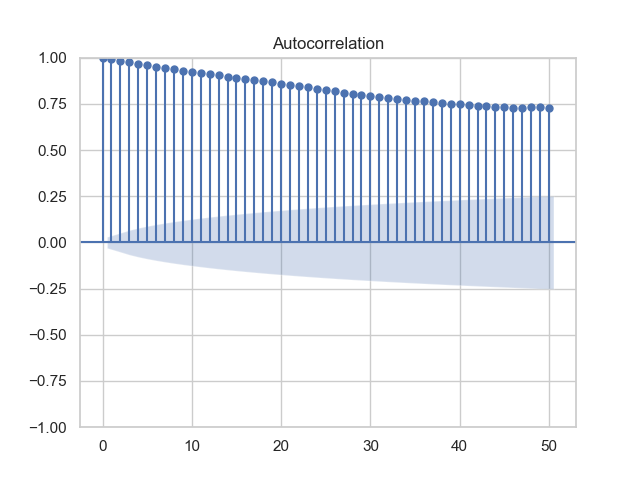

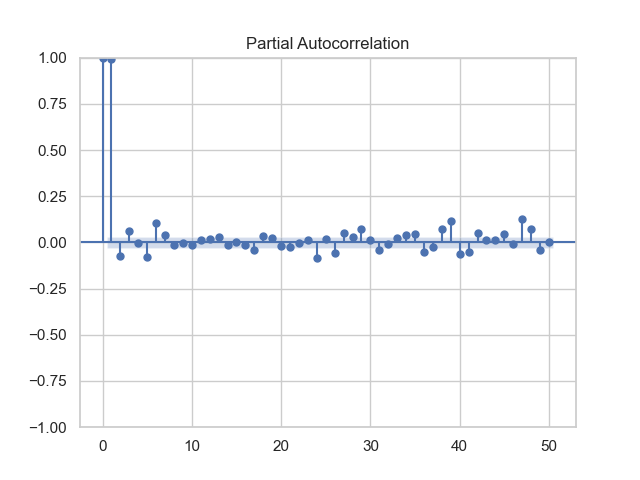

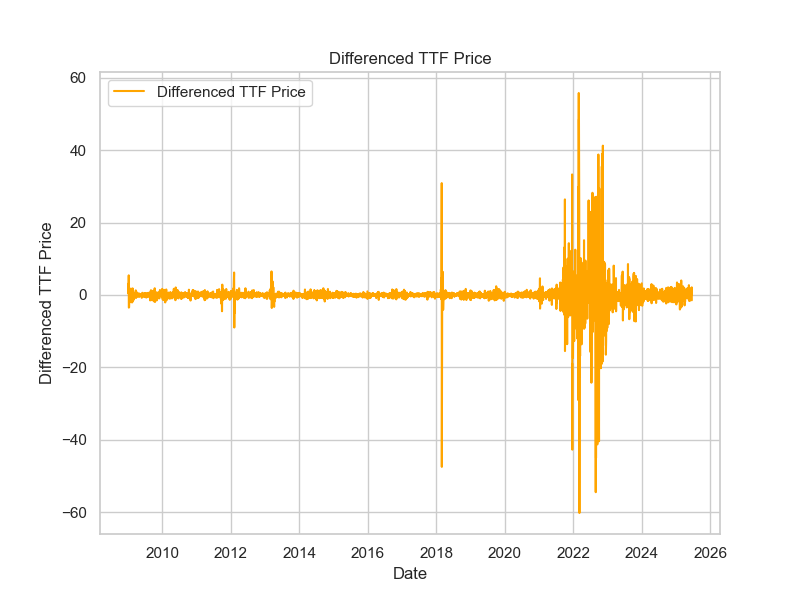

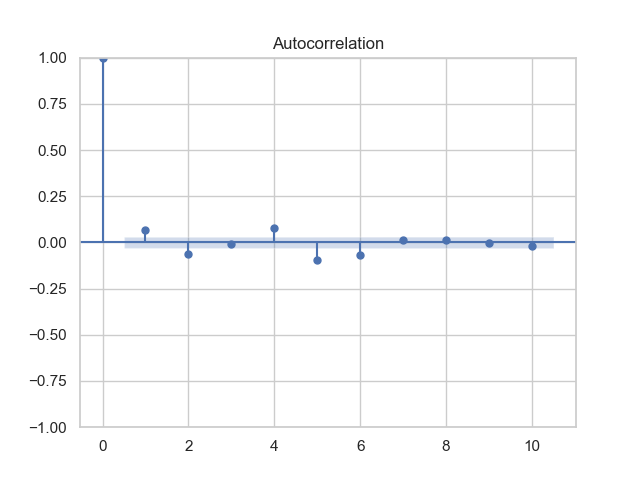

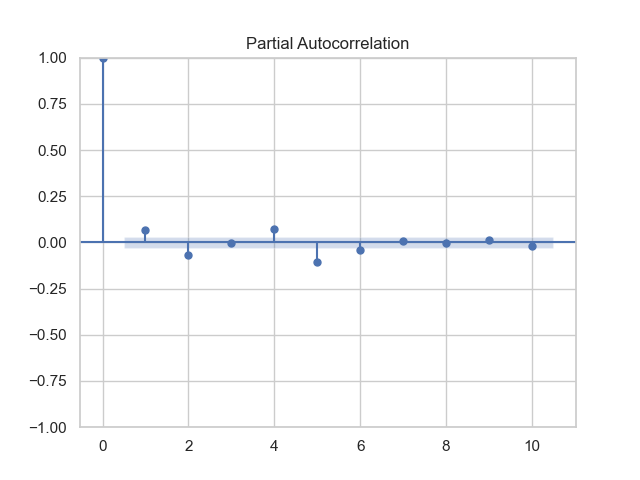

In [13]:
# Plot ACF and PACF
# Partial Autocorrelation Function
# https://www.geeksforgeeks.org/machine-learning/understanding-partial-autocorrelation-functions-pacf-in-time-series-data/
# PACF aids in identifying the order of autoregressive terms in autoregressive integrated moving average (ARIMA) models. 
# The distinct spikes in the PACF plot indicate the number of autoregressive terms required to model the data accurately.
plot_acf(df['ttf_price'].dropna(), lags=50)
plt.show()
plot_pacf(df['ttf_price'].dropna(), lags=50)
plt.show()

# Plot the differencing
plt.figure(figsize=(8, 6))
plt.plot(df['date'], df['ttf_price'].diff(), label='Differenced TTF Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Differenced TTF Price')
plt.title('Differenced TTF Price')
plt.legend()
plt.show()

plot_acf(df['ttf_price'].dropna().diff().dropna(), lags=10)
plt.show()
plot_pacf(df['ttf_price'].dropna().diff().dropna(), lags=10)
plt.show()
# First .dropna() cleans the original data.
# Second .dropna() removes the NaN from differencing.


In [ ]:
# series = df[['date', 'brent_price']].dropna(subset=['brent_price'])
# # column day of week
# series['week_of_day'] = series['date'].dt.dayofweek.astype(int)
# series = series.set_index('date')
# series = series.asfreq('B').interpolate() # Business frequency daily
# display(series)

## ARIMA

ARIMA model, or Autoregressive Integrated Moving Average model, is a statistical tool used for time series analysis and forecasting. It combines autoregressive (AR) and moving average (MA) models and incorporates differencing to make a time series stationary, enabling it to capture and predict patterns within data that changes over time. 

Key Components of an ARIMA Model:

* Autoregressive (AR) part: This part uses the past values of the time series to predict its future values. It essentially models the relationship between a data point and its preceding values. 
* Integrated (I) part: This refers to the differencing of the time series data. Differencing involves subtracting consecutive data points to make the series stationary, meaning its statistical properties (like mean and variance) do not change over time. Differencing is denoted by 'd' in the ARIMA notation. 
* Moving Average (MA) part: This part uses past forecast errors to predict future values. It models the relationship between a data point and the error terms from previous forecasts. 

ARIMA Notation:

An ARIMA model is typically denoted as ARIMA(p, d, q), where: 

* p: is the order of the autoregressive (AR) part (number of lag observations). 
* d: is the degree of differencing (number of times the data has been differenced). 
* q: is the order of the moving average (MA) part (number of lagged forecast errors). 

How it Works:
1. Stationarity:The first step in using an ARIMA model is to make the time series stationary, often by differencing the data. 
2. Model Identification:Based on the differenced data, the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots are analyzed to determine the appropriate values for p and q (the AR and MA orders). 
3. Parameter Estimation:Once the model structure is identified, the parameters of the AR and MA components are estimated. 
4. Forecasting:The fitted ARIMA model can then be used to forecast future values of the time series. 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19375D-01    |proj g|=  3.78416D-02


 This problem is unconstrained.



At iterate    5    f=  5.18191D-01    |proj g|=  6.58913D-03

At iterate   10    f=  5.18155D-01    |proj g|=  4.57969D-03

At iterate   15    f=  5.18062D-01    |proj g|=  1.28161D-03

At iterate   20    f=  5.18059D-01    |proj g|=  6.48182D-04

At iterate   25    f=  5.17974D-01    |proj g|=  5.21291D-03

At iterate   30    f=  5.17842D-01    |proj g|=  1.04570D-03

At iterate   35    f=  5.17783D-01    |proj g|=  5.40656D-03

At iterate   40    f=  5.17719D-01    |proj g|=  4.89326D-04

At iterate   45    f=  5.17715D-01    |proj g|=  1.74282D-04


/opt/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  5.17715D-01    |proj g|=  6.81174D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   6.812D-05   5.177D-01
  F =  0.51771524368335686     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/var/folders/qt/8nh0yrjj4q5dvgzzdm8s9j_40000gn/T/ipykernel_83506/3862260471.py:124: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



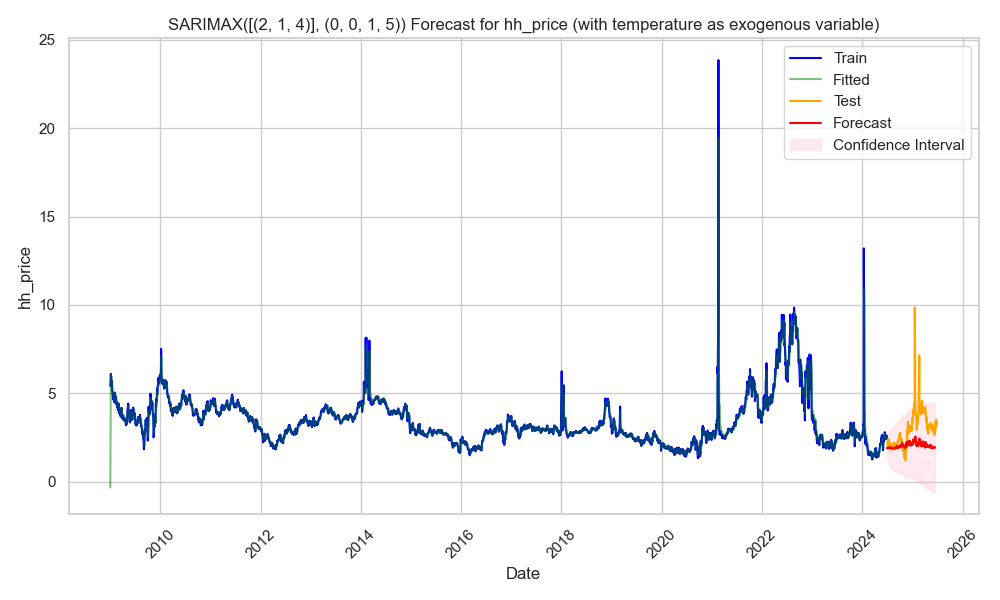

Test MSE and R2 for (2, 1, 4): 1.77329, -0.63863
AIC values for different ARIMA orders: ['4202.17']
BIC values for different ARIMA orders: ['4258.91']
MSE values for different ARIMA orders: ['0.00']
R^2 values for different ARIMA orders: ['1.00']


In [ ]:
# Fit ARIMA model and forecast the next 100 periods for 'ttf_price'
# Test a few models with different orders of ARIMA. Aggregate the AIC, BIC and MSE for comparison

order = [(4,1,5)]#, (30, 0, 1), (30, 1, 0), (30, 1, 1)]
seasonal_order = None

order = [(2,1,4)]
seasonal_order = (0,0,1,5)

aic_values = []
bic_values = []
mse_values = []
r2_values = []

whc = 'hh_price' #'hh_price'
end_date = '2024-06-30'
series = data_prep(df, whc, date_range=('2000-01-01', end_date))

forecast_steps = 250
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

# Suppose 'series' is your target series with a DatetimeIndex
changepoints = [
    '2012-04-01',
    '2014-02-01',
    '2016-03-01',
    '2018-11-01',
    '2020-06-01',
    '2021-10-01',
    '2022-08-01',
    '2023-03-01',
    '2024-01-01',
] # for hh_price

# Build exog for both training and forecast periods



# Prepare exogenous variables
#exog = exog_prep(df, 'temp_northern_hemisphere', series, steps=250)
exog_train, exog_test = exog_prep_train_test(df_t, whc.split('_')[0], series, steps=250)
#exog = None

if seasonal_order is not None:
    if exog_train is not None:
        # If seasonal order is provided, use SARIMAX
        title=f'SARIMAX({order}, {seasonal_order}) Forecast for {whc} (with temperature as exogenous variable)'
    else:
        # If seasonal order is provided but no exogenous variable, use SARIMAX without exog
        title=f'SARIMAX({order}, {seasonal_order}) Forecast for {whc}'
else:
    # If no seasonal order is provided, use ARIMA
    seasonal_order = None
    # Use the same title format for ARIMA
    if exog_train is not None:
        title=f'ARIMA{order} Forecast for {whc} (with temperature as exogenous variable)'
    else:
        title=f'ARIMA{order} Forecast for {whc}'

for ord in order:
    # Fit ARIMA model and forecast
    results, _, forecast = fit_arima_sarimax_and_forecast(
        series, 
        order=ord,
        seasonal_order=seasonal_order, 
        steps=forecast_steps, 
        print_summary=False, 
        exog_train=exog_train,
        exog_test=exog_test
    )
    # Use the same filtered series as in ARIMA fitting
    # Plot the forecast
    conf_int = forecast.conf_int(alpha=0.2)
    plot_forecast(
        series, 
        results.fittedvalues, 
        forecast.predicted_mean, 
        conf_int.values, 
        forecast_index, 
        series_other=data_prep(df, whc, date_range=(end_date, '2025-12-31')),
        ylabel=whc,
        title= title
    )

    # Collect AIC, BIC, and MSE
    aic_values.append(results.aic)
    bic_values.append(results.bic)
    
    # Align and drop NaNs before computing MSE
    actual = series[whc]
    fitted = results.fittedvalues
    aligned = pd.concat([actual, fitted], axis=1, join='inner').dropna()
    mse_values.append(mean_squared_error(aligned[whc], aligned[whc]))

    # R^2 (coefficient of determination)
    r2 = r2_score(aligned[whc], aligned[whc])
    r2_values.append(r2)

    # Calculate test MSE
    test_series = data_prep(df, whc, date_range=(end_date, '2025-12-31'))
    test_fitted = forecast.predicted_mean.reindex(test_series.index)
    test_aligned = pd.concat([test_series[whc], test_fitted], axis=1, join='inner').dropna()
    test_mse = mean_squared_error(test_aligned[whc], test_aligned['predicted_mean'])
    r2_test = r2_score(test_aligned[whc], test_aligned['predicted_mean'])
    print(f"Test MSE and R2 for {ord}: {test_mse:.5f}, {r2_test:.5f}")

print("AIC values for different ARIMA orders:", [f"{v:.2f}" for v in aic_values])
print("BIC values for different ARIMA orders:", [f"{v:.2f}" for v in bic_values])
print("MSE values for different ARIMA orders:", [f"{v:.2f}" for v in mse_values])
print("R^2 values for different ARIMA orders:", [f"{v:.2f}" for v in r2_values])

Test MSE and R2 for
ARIMA: 94.34195, -1.55611
SARIMAX: 86.11625, -1.33325

When the ARIMA prediction is a flat line, it means the model is forecasting the future values as a constant, typically equal to the last observed value or the mean of the differenced series. This usually happens because:

* The time series is stationary after differencing, with no clear trend or seasonality left for the model to learn.
* The ARIMA parameters (especially with order (1,1,1)) may not capture any remaining structure, so the best prediction is simply to repeat the last value.
* The model does not detect any significant autocorrelation or pattern to project forward.

In summary:
A flat ARIMA forecast suggests the model expects no change in the future, based on the information it has learned from the historical data. This can indicate either a lack of predictive structure in the data or that the model parameters need to be tuned or made more complex.

## SARIMAX

The general SARIMAX model can be expressed as: SARIMAX(p, d, q)(P, D, Q, s) where:

* p, d, q: Non-seasonal parameters representing autoregressive (AR), integrated (I), and moving average (MA) components.
* P, D, Q: Seasonal parameters analogous to p, d, q, but for the seasonal component.
* s: The seasonal period (e.g., 12 for monthly data with yearly seasonality).
* X: Exogenous variables.

In essence, SARIMAX allows you to model:

1. Autoregression (AR): How the current value of the time series is related to its past values. 
2. Integration (I): How many times the time series needs to be differenced to achieve stationarity (making it suitable for modeling). 
3. Moving Average (MA): How the current value is influenced by past forecast errors. 
4. Seasonality (S): Recurring patterns at specific intervals. 
5. Exogenous Factors (X): External variables that impact the time series. 

In [ ]:
# Fit the SARIMAX model
# Very long running, so test on a smaller subset of data

# Convert string to datetime.date for slicing
start = datetime.strptime('2022-01-01', '%Y-%m-%d').date()
end = datetime.strptime('2024-12-31', '%Y-%m-%d').date()

ttf_series_part = ttf_series.loc[start:end]  # Slice the series by date range

x = ttf_series_part.index
y = ttf_series_part['ttf_price']

#exog = df[['coal_price', 'brent_price', 'cboe_price']].dropna().reindex(y.index)  # Ensure exogenous variables align with y
model = SARIMAX(ttf_series_part, order=(1,1,1), seasonal_order=(1,1,1,5))#, exog=exog) # 252 for trading days
results = model.fit()
print(results.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58809D+00    |proj g|=  7.40212D-02

At iterate    5    f=  3.43051D+00    |proj g|=  4.63844D-02

At iterate   10    f=  3.42814D+00    |proj g|=  4.75097D-03

At iterate   15    f=  3.42689D+00    |proj g|=  2.53016D-04

At iterate   20    f=  3.42688D+00    |proj g|=  1.31901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   1.614D-05   3.427D+00
  F =   3.4268813717459641     

CONVERG

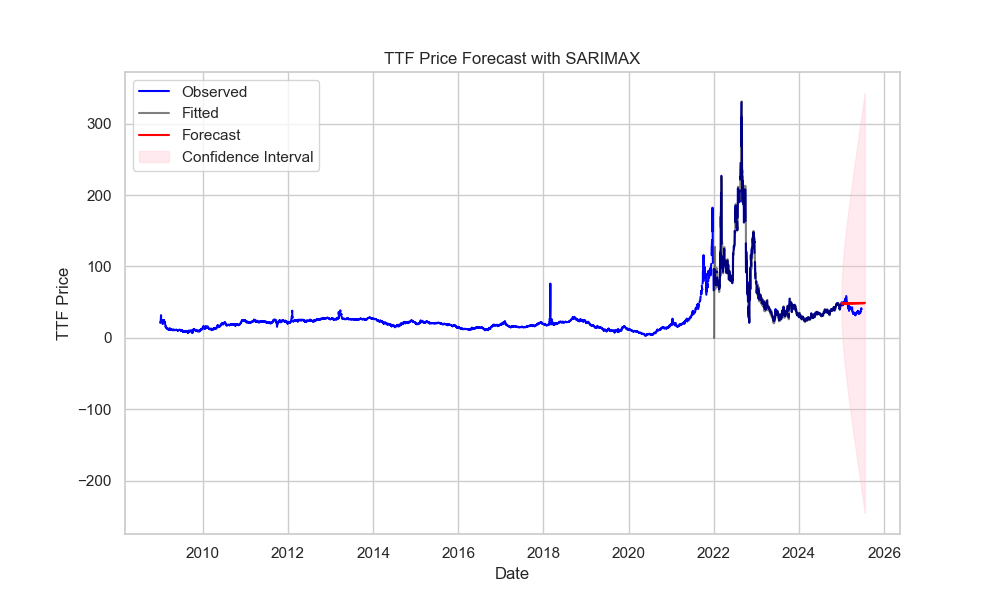

In [55]:
# Plot the forecast
plt.figure(figsize=(10, 6))

# Forecasting the next 200 days with SARIMAX
horizon_days = 200
forecast = results.get_forecast(steps=horizon_days)
forecast_index = pd.date_range(start=x[-1], periods=horizon_days+1, freq='D')[1:]

#plt.plot(x, y, label='Observed', color='blue')
plt.plot(df['date'], df['ttf_price'], label='Observed', color='blue')
plt.plot(x, results.fittedvalues, label='Fitted', color='black', alpha=0.5)
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast.conf_int()['lower ttf_price'],
                 forecast.conf_int()['upper ttf_price'],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('TTF Price')
plt.title('TTF Price Forecast with SARIMAX')
plt.legend()
plt.show()

## Seasonality trend decomposition

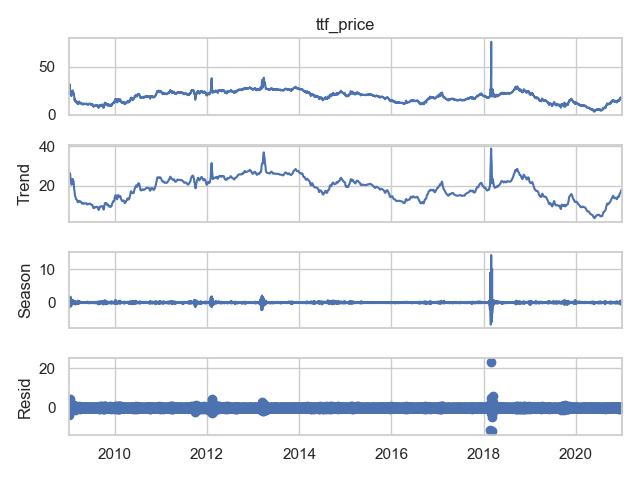

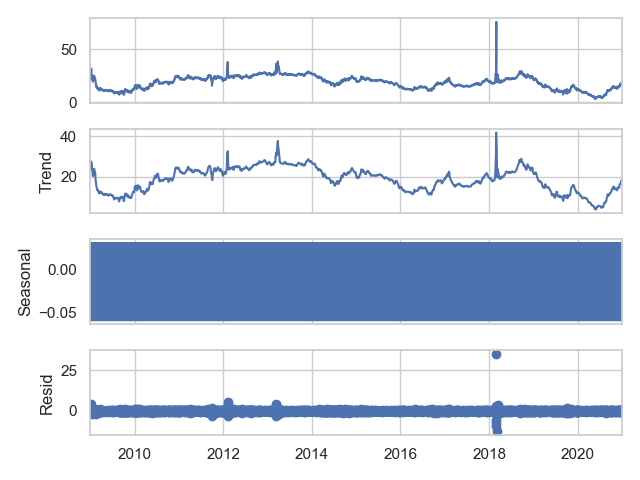

In [65]:
# Seasonal decomposition using STL and statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

series = data_prep(df, 'ttf_price', date_range=('2000-01-01', '2020-12-31'))

# STL decomposition
stl = STL(series['ttf_price'], seasonal=5)
result = stl.fit()
result.plot()
plt.show()

# Seasonal decomposition
seasonal_decompose(series, model='additive').plot()
plt.show()

## Expinential smoothing

Good especially when your data shows trends or seasonality.

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



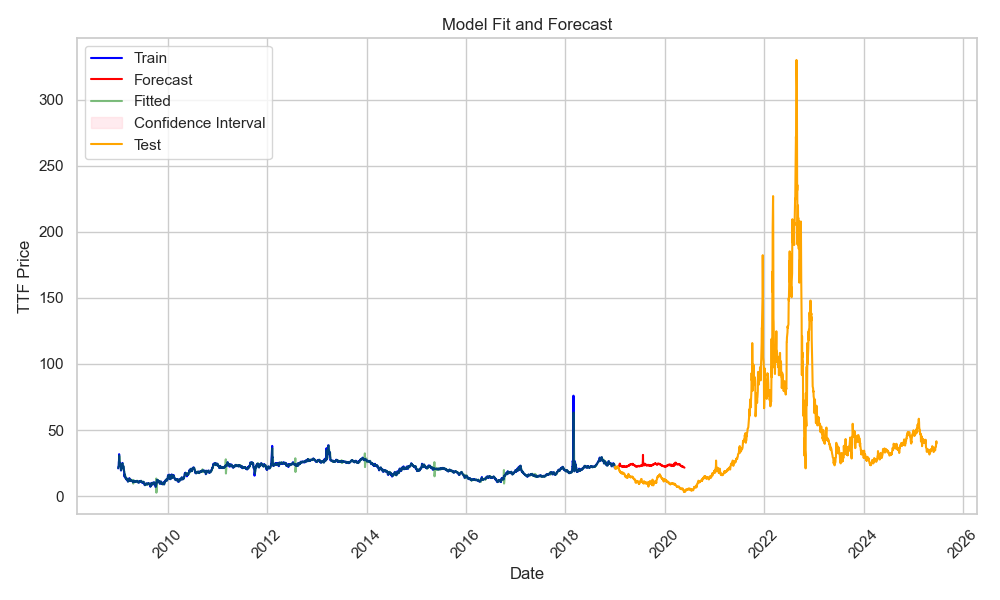

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

start_date = '2000-01-01'
end_date = '2024-06-30'

start_date = '2000-01-01'
end_date = '2018-12-31'

# Prepare your series (must be 1D, no missing values)
series = data_prep(df, 'ttf_price', date_range=(start_date, end_date))

model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=365)
fit = model.fit()

horizon_days = 365  # Forecast horizon in days
forecast = fit.forecast(horizon_days)
# Confidence intervals are not directly available; set to NaN for plotting
conf_int = np.full((horizon_days, 2), np.nan)
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=horizon_days, freq='B')

# Plot the Exponential Smoothing forecast
plot_forecast(series, fit.fittedvalues, forecast, conf_int, forecast_index, 
                  series_other=data_prep(df, 'ttf_price', date_range=(end_date, '2025-12-31')),
                  ylabel='TTF Price')

In [ ]:
# Test number of differences needed to make the series stationary
from pmdarima.arima import ndiffs, nsdiffs

series = data_prep(df, 'ttf_price', date_range=('2000-01-01', '2021-12-31'))

# Calculate the number of differences needed to make the series stationary
n_diffs = ndiffs(series['ttf_price'], test='adf')  # m=365 for weekly seasonality
print(f"Number of differences needed: {n_diffs}")

# Calculate the number of seasonal differences needed
seasonal_diffs = nsdiffs(series['ttf_price'], m=5)  # m=5 for weekly seasonality
print(f"Number of seasonal differences needed: {seasonal_diffs}")

Number of differences needed: 1
Number of seasonal differences needed: 0


/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: Fu

In [ ]:

whc = 'hh_price'  # Change to the column you want to analyze
whct = whc.split('_')[0]  # Extract the prefix for temperature column
start_date = '2010-01-01'
end_date = '2018-06-30'

# Prepare data series (must be 1D, no missing values)
series = data_prep(df, whc, date_range=(start_date, end_date))

forecast_steps = 250
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

#############################
# Prepare exogenous variables
#############################
# Lag temperature features from df_t
exog_train_list = []
exog_test_list = []
for lag in [0]:#, 1, 2, 6, 12, 24, 36, 48, 96]:
    df_t[whct + f'_t_lag{lag}'] = df_t[whct].shift(lag)
    s_train, s_test = exog_prep_train_test(df_t, whct + f'_t_lag{lag}', series, steps=forecast_steps)
    exog_train_list.append(s_train)
    exog_test_list.append(s_test)
# Concatenate the lagged temperature features
exog_train = pd.concat(exog_train_list, axis=1)
exog_test = pd.concat(exog_test_list, axis=1)

# Temperature^2
df_t[whct + '_t_squared'] = df_t[whct] ** 2
s_train, s_test = exog_prep_train_test(df_t, whct + '_t_squared', series, steps=forecast_steps)
exog_train = pd.concat([exog_train, s_train], axis=1)
exog_test = pd.concat([exog_test, s_test], axis=1)

# Extreme temperature features
# df_t[whct + '_t_extreme_hot'] = df_t[whct].apply(lambda x: 1 if (x > 25) else 0)  # Example threshold for extreme temperature
# s_train, s_test = exog_prep_train_test(df_t, whct + '_t_extreme_hot', series, steps=forecast_steps)
# exog_train = pd.concat([exog_train, s_train], axis=1)
# exog_test = pd.concat([exog_test, s_test], axis=1)

df_t[whct + '_t_extreme_cold'] = df_t[whct].apply(lambda x: 1 if (x < 5) else 0)  # Example threshold for extreme temperature
s_train, s_test = exog_prep_train_test(df_t, whct + '_t_extreme_cold', series, steps=forecast_steps)
exog_train = pd.concat([exog_train, s_train], axis=1)
exog_test = pd.concat([exog_test, s_test], axis=1)

# Categorical variables for Covid-19 and war in Ukraine and other significant events
# Create binary variables for significant events
exog_train = add_event_features(exog_train, idx_col=exog_train.index.name)
exog_test = add_event_features(exog_test, idx_col=exog_test.index.name)

# Standardize the data, exogenous variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
series_scaled = pd.DataFrame(scaler.fit_transform(series), index=series.index, columns=series.columns)
scaler_exog = StandardScaler()
exog_train_scaled = pd.DataFrame(scaler_exog.fit_transform(exog_train), index=exog_train.index, columns=exog_train.columns)
exog_test_scaled = pd.DataFrame(scaler_exog.transform(exog_test), index=exog_test.index, columns=exog_test.columns)

# Fit the ARIMA model using auto_arima
# Note: auto_arima will automatically determine the best order for ARIMA/SARIMAX
model = pm.auto_arima(series_scaled, exog_train_scaled,
    seasonal=False,
    m=1,  # set to your seasonal period (e.g., 5 for weekly, 12 for monthly)
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(model.summary())

forecast, conf_int = model.predict(n_periods=forecast_steps, X=exog_test_scaled, return_conf_int=True)
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1284.359, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5112.871, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1035.844, Time=0.95 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2760.732, Time=0.70 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1235.510, Time=1.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1158.910, Time=1.68 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1280.271, Time=2.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1258.638, Time=1.74 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1127.411, Time=1.24 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1284.208, Time=1.77 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1209.946, Time=1.84 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-1292.985, Time=1.84 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-1264.712, Time=1.95 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-1295.486, Time=3.94 sec
 ARIMA(2,0,4)(0,0,0)[

In [ ]:
# drop the exogenous variables in the df_t DataFrame
for col in exog_train.columns:
    if col in df_t.columns:
        df_t.drop(columns=col, inplace=True)
    if col in df.columns:
        df.drop(columns=col, inplace=True)

Mean Absolute Error (MAE): 3.27920
R^2 Score: -36.23465


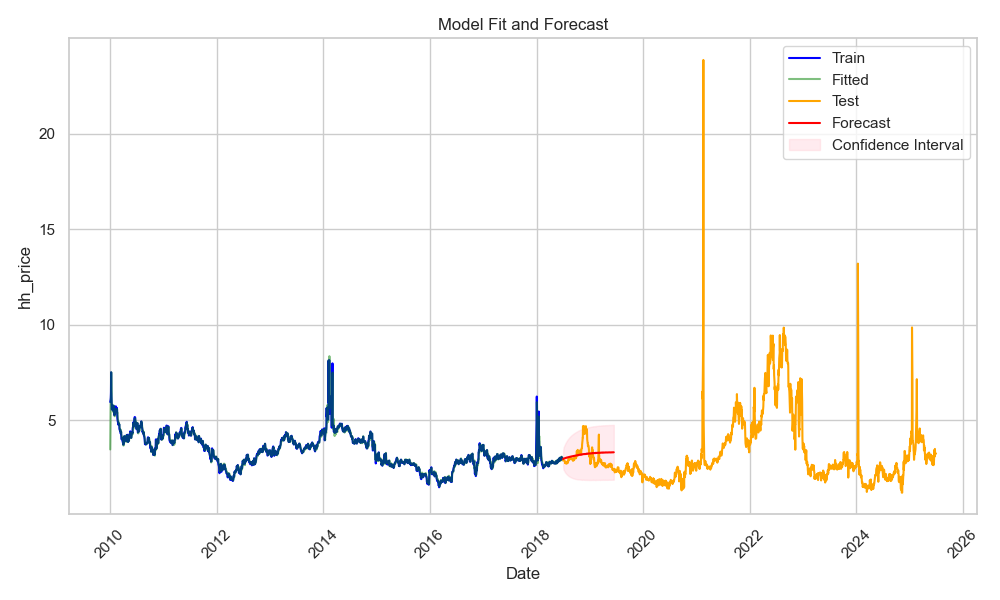

In [ ]:
# Calculate MAE and R^2 for the forecast
from sklearn.metrics import mean_absolute_error, r2_score
actual = data_prep(df, whc, forecast_index)
forecast_series = pd.Series(forecast, index=forecast_index, name='predicted_mean')
mae = mean_absolute_error(actual, forecast_series)
r2 = r2_score(actual, forecast_series)
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"R^2 Score: {r2:.5f}")

plot_forecast(
    series, 
    scaler.inverse_transform(model.predict_in_sample(X=exog_train_scaled).values.reshape(-1, 1)),
    scaler.inverse_transform(forecast.values.reshape(-1, 1)),
    scaler.inverse_transform(conf_int),
    forecast_index,
    series_other=data_prep(df, whc, date_range=(end_date, '2025-12-31')),
    ylabel=whc
)

In [113]:
df

date  psv_price  brent_price  ttf_futures_price  pvb_price  \
0     2009-01-01        NaN          NaN                NaN        NaN   
1     2009-01-02        NaN        46.91                NaN        NaN   
2     2009-01-03        NaN          NaN                NaN        NaN   
3     2009-01-04        NaN          NaN                NaN        NaN   
4     2009-01-05        NaN        49.62                NaN        NaN   
...          ...        ...          ...                ...        ...   
6205  2025-12-28        NaN          NaN                NaN        NaN   
6206  2025-12-29        NaN          NaN                NaN        NaN   
6207  2025-12-30        NaN          NaN                NaN        NaN   
6208  2025-12-31        NaN          NaN                NaN        NaN   
6209  2026-01-01        NaN          NaN                NaN        NaN   

      jkm_price  nbp_price  cboe_price  coal_price  hh_price  ttf_price  \
0           NaN        NaN         NaN         NaN       NaN      21.00   
1           NaN        NaN       39.19       74.35      5.41      22.20   
2           NaN        NaN         NaN         NaN       NaN        NaN   
3           NaN        NaN         NaN         NaN       NaN        NaN   
4           NaN        NaN       39.08       77.65      5.83      22.85   
...         ...        ...         ...         ...       ...        ...   
6205        NaN        NaN         NaN         NaN       NaN        NaN   
6206        NaN        NaN         NaN         NaN       NaN        NaN   
6207        NaN        NaN         NaN         NaN       NaN        NaN   
6208        NaN        NaN         NaN         NaN       NaN        NaN   
6209        NaN        NaN         NaN         NaN       NaN        NaN   

      brent_volume  ttf_futures_volume  coal_volume  temp_global  \
0              NaN                 NaN          NaN       12.580   
1          85070.0                 NaN          NaN       12.503   
2              NaN                 NaN          NaN       12.442   
3              NaN                 NaN          NaN       12.416   
4         109470.0                 NaN          NaN       12.432   
...            ...                 ...          ...          ...   
6205           NaN                 NaN          NaN          NaN   
6206           NaN                 NaN          NaN          NaN   
6207           NaN                 NaN          NaN          NaN   
6208           NaN                 NaN          NaN          NaN   
6209           NaN                 NaN          NaN          NaN   

      temp_southern_hemisphere  temp_northern_hemisphere  netimports_total  \
0                       15.963                     9.254          694352.0   
1                       15.952                     9.109           27910.0   
2                       16.003                     8.938          -14882.0   
3                       16.097                     8.792         -193166.0   
4                       16.191                     8.730           64498.0   
...                        ...                       ...               ...   
6205                       NaN                       NaN               NaN   
6206                       NaN                       NaN               NaN   
6207                       NaN                       NaN               NaN   
6208                       NaN                       NaN               NaN   
6209                       NaN                       NaN               NaN   

      inventories_global  week_of_day  
0                    NaN            3  
1                    NaN            4  
2                    NaN            5  
3                    NaN            6  
4                    NaN            0  
...                  ...          ...  
6205                 NaN            6  
6206                 NaN            0  
6207                 NaN            1  
6208                 NaN            2  
6209                 NaN    

In [115]:
# Plotly plot for the global inventory in the df DataFrame
import plotly.express as px

fig = px.line(df, x='date', y=['hh_price', 'inventories_global'], title='Global Inventory Over Time')
fig.show()

In [103]:
# Plotly plot check the new lag, squared, and extreme temperature features
import plotly.express as px

# Prepare the data for Plotly
exog_train_melted = exog_train.reset_index().melt(id_vars='date', var_name='feature', value_name='value')
exog_test_melted = exog_test.reset_index().melt(id_vars='date', var_name='feature', value_name='value')

# Plot the training data
fig = px.line(exog_train_melted, x='date', y='value', color='feature', title='Exogenous Variables (Training)')
fig.show()

# Plot the test data
fig = px.line(exog_test_melted, x='date', y='value', color='feature', title='Exogenous Variables (Test)')
fig.show()


# Knowledge

## Time Series Cross-Validation or Rolling/Expanding Window Cross-Validation.

The most common methods are:

1. Rolling Window (Sliding Window) Validation
Train on a fixed-size window, test on the next period, then slide the window forward.
Example:
* Train: [1, 2, 3, 4, 5], Test: [6]
* Train: [2, 3, 4, 5, 6], Test: [7]
And so on.
2. Expanding Window Validation
Start with an initial training set, then expand the training set with each iteration.
Example:
* Train: [1, 2, 3, 4, 5], Test: [6]
* Train: [1, 2, 3, 4, 5, 6], Test: [7]
And so on.
3. Blocked Time Series Split
The data is split into contiguous blocks, preserving order, for train/test splits.
In scikit-learn:
You can use TimeSeriesSplit


## 

for SARIMAX and most classical time series models, it is generally better to train on the full available series (up to the forecast point), especially if:

The time series is stationary or its statistical properties do not change much over time.
You want to capture as much information and pattern as possible from the data.
Exceptions:

If the series is non-stationary (e.g., structural breaks, regime changes), a rolling or expanding window may be better.
If you want the model to adapt to recent changes only, use a recent window.
Summary:

For most cases, train SARIMAX on the full series for best results.
Use a window only if you have reason to believe older data is not relevant.

# Conclusions & Takeaways

- Classical models provide interpretable baselines and help validate stationarity and seasonality assumptions (ADF, ACF/PACF, STL decomposition).
- SARIMAX and auto_arima can capture regular patterns but may underperform around structural breaks (COVID, war-related events). Include event indicators as exogenous regressors when appropriate.
- Use exponential smoothing for fast baseline forecasts; use Prophet or neural models when you need changepoint-awareness or complex covariate handling.

Recommended next steps:
- Standardize train/test splits and add a rolling/expanding cross-validation block for robust evaluation.
- Add a lightweight "Quick run" cell that fits a very small ARIMA on a short date range so reviewers can preview results without long runs.
- Compare results in `2_autoArma_prophet.ipynb` and `3_ANN_models.ipynb` for model selection.